# Media Mix Modeling (MMM) Tutorial

This notebook demonstrates how to build and analyze a Marketing Mix Model using PyMC Marketing.

## Prepare Notebook

Let's import the necessary libraries:

In [1]:
import sys
sys.path.insert(0, ".")

import yaml
from pymc_marketing.mmm.mmm import MMM

# Load configuration from YAML file
with open("mmm_config.yml", "r") as f:
    config = yaml.safe_load(f)

print("Configuration loaded successfully!")
print(f"Data source: {config['data']['source']}")
print(f"Channel columns: {config['data']['columns']['channel_columns']}")
print(f"MCMC chains: {config['sampling']['mcmc']['chains']}")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


Configuration loaded successfully!
Data source: https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/mmm_example.csv
Channel columns: ['x1', 'x2']
MCMC chains: 4


## Enhanced Logging

The MMM classes now include comprehensive logging to help you track the modeling process. Let's configure logging to see detailed information about what's happening during model operations:

In [2]:
# DEBUG: Check logging state before configuration
import logging
root = logging.getLogger()
print(f"=== BEFORE configuring logging ===")
print(f"Root logger handlers: {len(root.handlers)}")
print(f"Root handlers: {root.handlers}")
for i, handler in enumerate(root.handlers):
    print(f"  Handler {i}: {handler}")


=== BEFORE configuring logging ===
Root logger handlers: 0
Root handlers: []


In [3]:
# Configure logging using settings from config
import logging

# Get logging configuration from config
log_config = config['logging']

# Prevent duplicate logs by clearing existing root handlers first
# This is essential in Jupyter notebooks where handlers accumulate
root_logger = logging.getLogger()
if root_logger.hasHandlers():
    root_logger.handlers.clear()

# Apply base configuration to ROOT only (single StreamHandler)
logging.basicConfig(
    level=getattr(logging, log_config['level']),
    format=log_config['format'],
    datefmt=log_config['date_format']
)

# Harden against duplicates from library loggers that might have their own handlers
# 1) Ensure all pymc_marketing* loggers don't keep stale handlers across reruns
for name in list(logging.root.manager.loggerDict.keys()):
    if isinstance(logging.root.manager.loggerDict[name], logging.Logger):
        # Some entries in loggerDict can be PlaceHolder; guard for Logger
        pass
    if name.startswith("pymc_marketing"):
        pkg_logger = logging.getLogger(name)
        # Remove any handlers that may have been attached in a previous run
        for h in list(pkg_logger.handlers):
            pkg_logger.removeHandler(h)
        # Let messages bubble up to ROOT (which has exactly one handler now)
        pkg_logger.propagate = True
        # Respect configured level (so you can tune verbosity per package)
        pkg_logger.setLevel(getattr(logging, log_config['mmm_logger']['level']))

# Optionally quiet very chatty external loggers if needed
# Avoid duplicate/verbose logs from PyMC internal forward sampler, not relevant for prior predictive
logging.getLogger("pymc.sampling.forward").propagate = False

# Configure the main MMM logger name from config, but don't add handlers to it
mmm_logger = logging.getLogger(log_config['mmm_logger']['name'])
mmm_logger.setLevel(getattr(logging, log_config['mmm_logger']['level']))
# Ensure it has no handlers and uses ROOT's single handler
for h in list(mmm_logger.handlers):
    mmm_logger.removeHandler(h)
mmm_logger.propagate = True

print("Logging configured! Now all MMM operations will show detailed process information without duplicates.")

Logging configured! Now all MMM operations will show detailed process information without duplicates.


Now when you run the MMM operations below, you'll see detailed logging information including:

- **Model Initialization**: Input parameters, configuration details
- **Data Preprocessing**: Data shapes, statistics, date ranges  
- **Model Building**: Variables created, model coordinates, scaling factors
- **Prior/Posterior Sampling**: Input parameters, output shapes, variable lists
- **Model Fitting**: Fit parameters, inference data groups

This logging helps with debugging, monitoring, and understanding what the model is doing at each step.

In [4]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymc_extras.prior import Prior
import jax 
import pytensor 
from pymc_marketing.mmm.components.adstock import GeometricAdstock
from pymc_marketing.mmm.components.saturation import LogisticSaturation

import numpyro 

# Apply visualization configuration from config file
viz_config = config['visualization']
az.style.use(viz_config['style'])
plt.rcParams["figure.figsize"] = viz_config['figure']['figsize']
plt.rcParams["figure.dpi"] = viz_config['figure']['dpi']

%config InlineBackend.figure_format = viz_config['backend']['format']

%load_ext autoreload
%autoreload 2

c:\Users\David Rodriguez\Desktop\Developer\4M Project\pymc_marketing\mmmenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Set random seed for reproducibility from config
seed = config['sampling']['random_seed']
rng = np.random.default_rng(seed=seed)
print(f"Random seed set to: {seed}")

Random seed set to: 327


## Load Data

We'll use a synthetic dataset that simulates weekly sales data along with spend on two marketing channels (x1 and x2), plus some control variables for special events.

In [6]:
# Load the data from config-specified source
data_config = config['data']
url = data_config['source']
data = pd.read_csv(url, parse_dates=[data_config['columns']['date_column']])

print(f"Data shape: {data.shape}")
data.head()

Data shape: (179, 8)


,date_week,y,x1,x2,event_1,event_2,dayofyear,t
0,2018-04-02,3984.662237,0.318580,0.0,0.0,0.0,92,0
1,2018-04-09,3762.871794,0.112388,0.0,0.0,0.0,99,1
2,2018-04-16,4466.967388,0.292400,0.0,0.0,0.0,106,2
3,2018-04-23,3864.219373,0.071399,0.0,0.0,0.0,113,3
4,2018-04-30,4441.625278,0.386745,0.0,0.0,0.0,120,4


Let's visualize our target variable (sales) and the media spend over time:

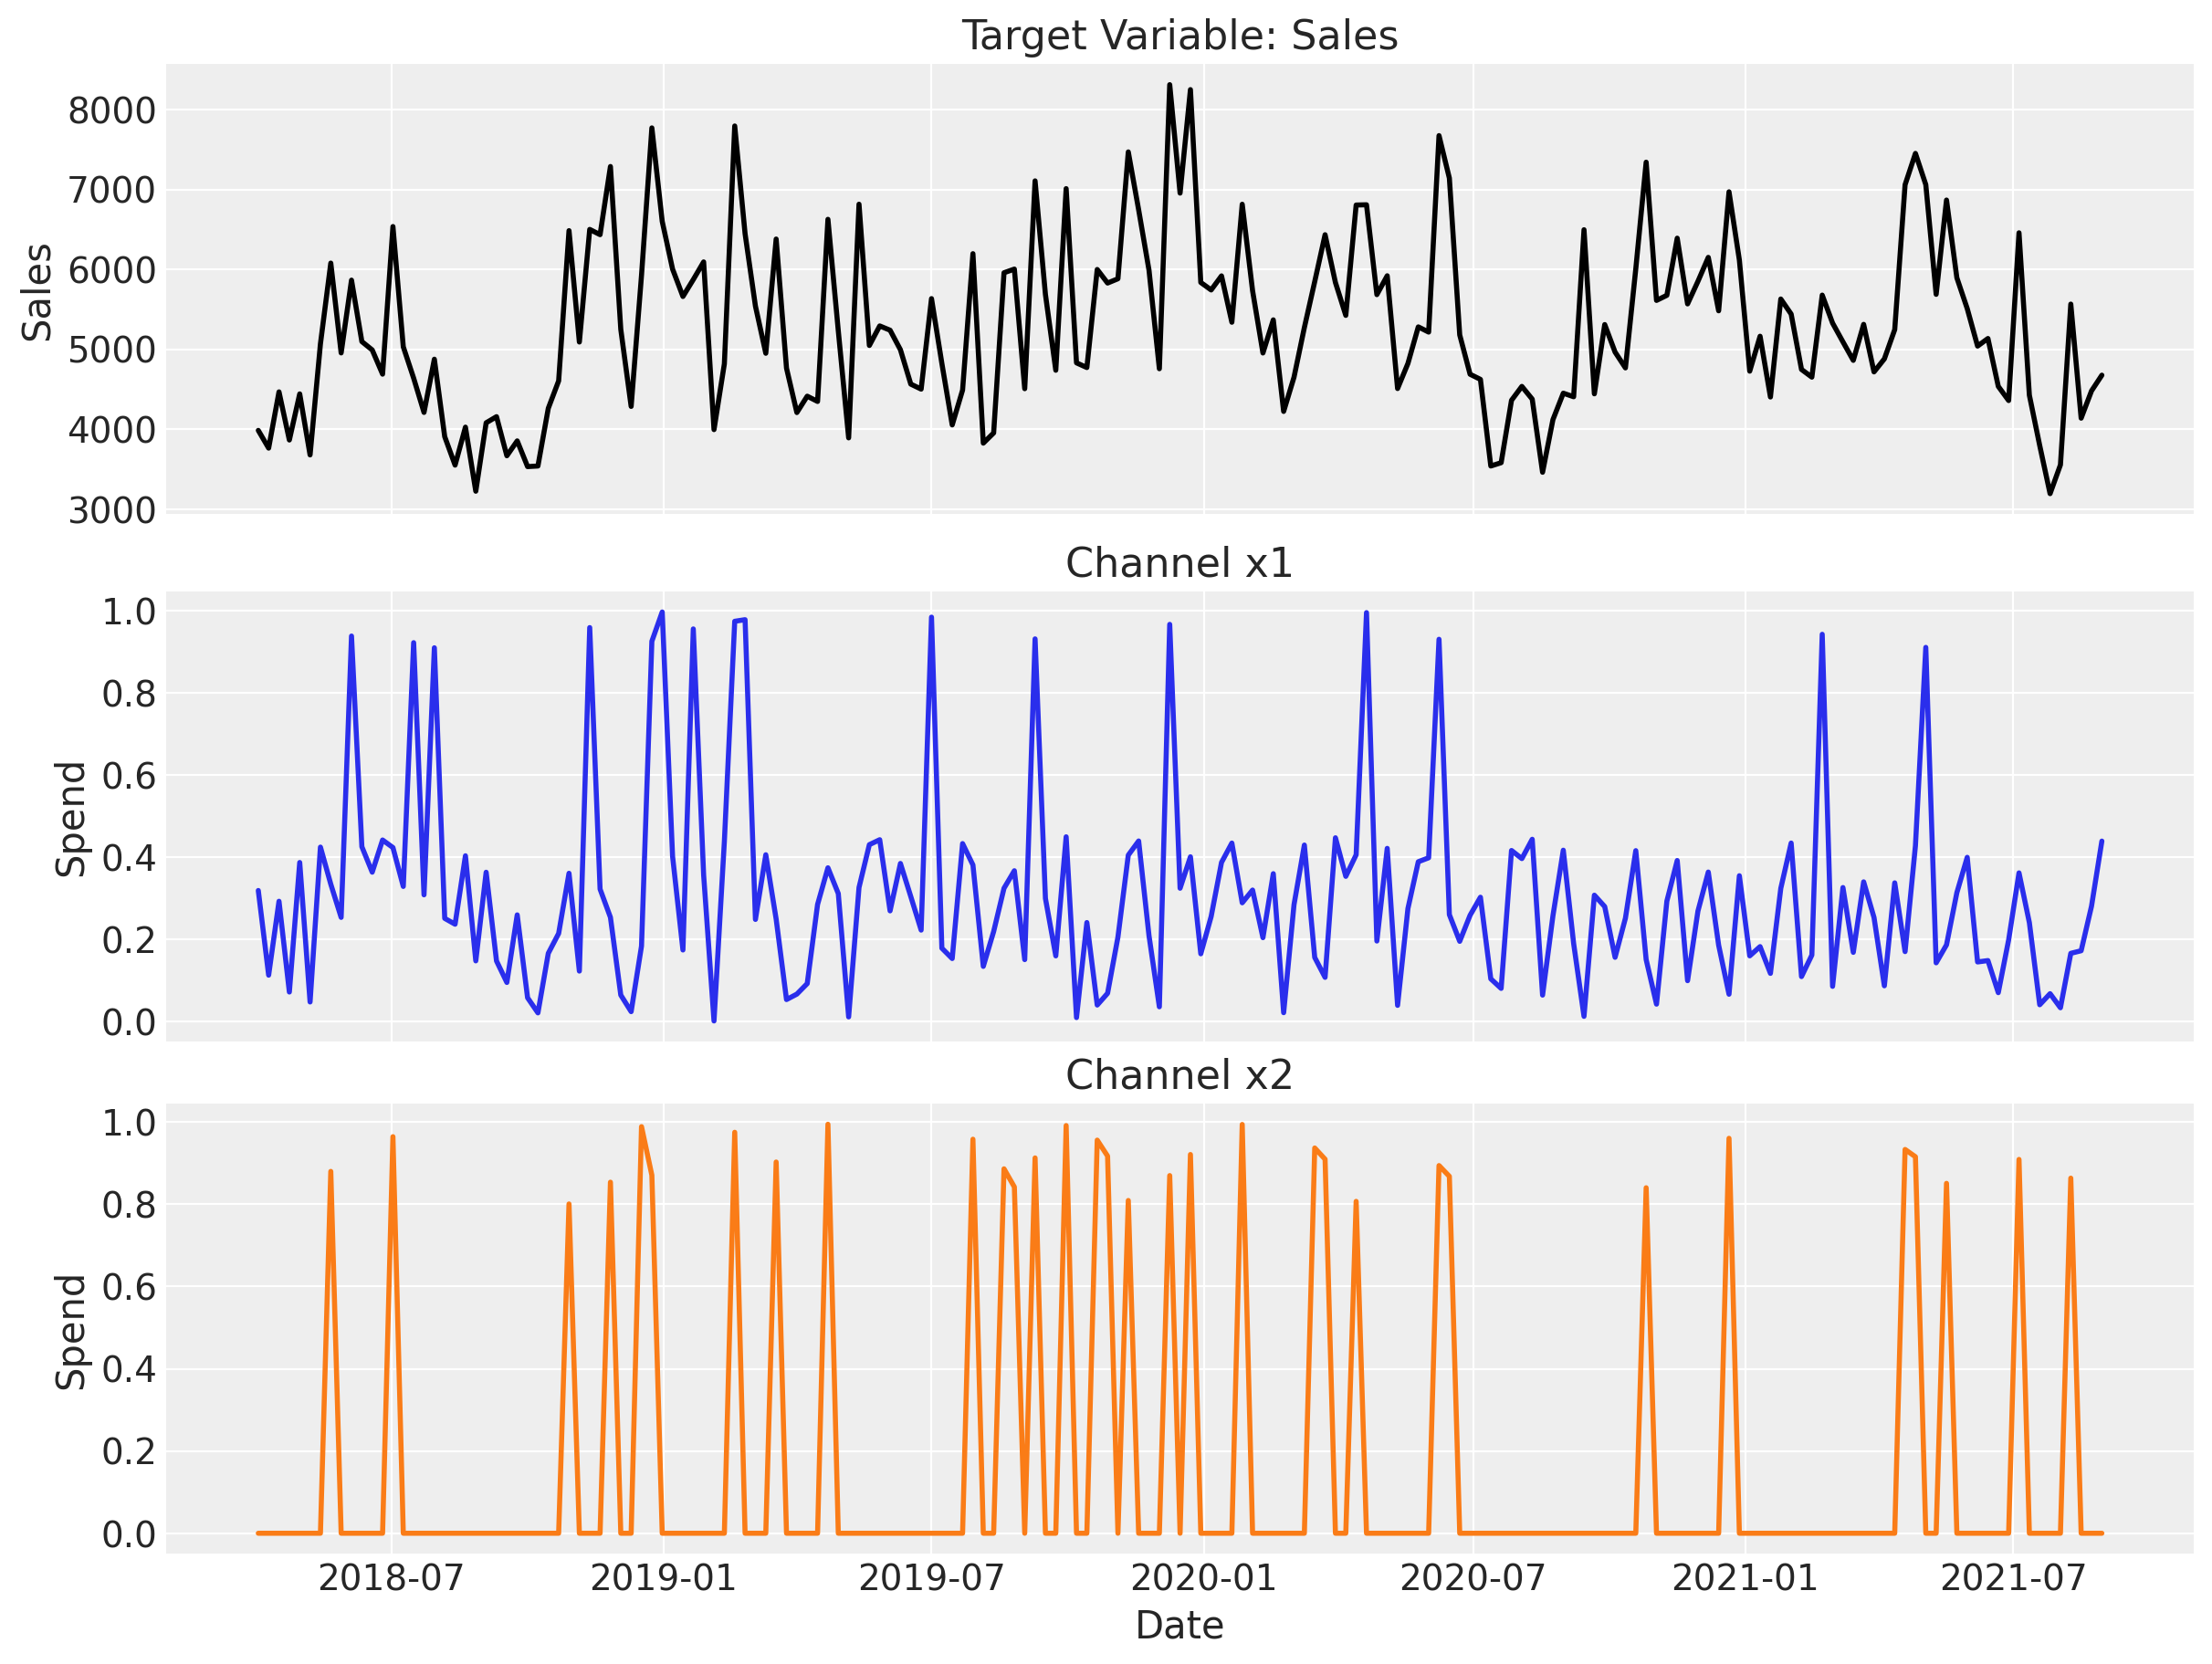

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# Get column names from config
date_col = config['data']['columns']['date_column']
target_col = config['data']['columns']['target_column']
channel_cols = config['data']['columns']['channel_columns']

# Sales
axes[0].plot(data[date_col], data[target_col], color="black", linewidth=2)
axes[0].set(ylabel="Sales", title="Target Variable: Sales")

# Channel 1
axes[1].plot(data[date_col], data[channel_cols[0]], color="C0", linewidth=2)
axes[1].set(ylabel="Spend", title=f"Channel {channel_cols[0]}")

# Channel 2
axes[2].plot(data[date_col], data[channel_cols[1]], color="C1", linewidth=2)
axes[2].set(xlabel="Date", ylabel="Spend", title=f"Channel {channel_cols[1]}");

## Feature Engineering

For our MMM model, we'll include:

- **Trend**: A linear trend to capture long-term growth
- **Seasonality**: Yearly seasonality (handled automatically by the model)
- **Events**: Binary indicators for special events
- **Media channels**: Our two advertising channels

In [8]:
# Add a simple linear trend feature
data["t"] = range(len(data))

# Split into features (X) and target (y) using config
target_col = config['data']['columns']['target_column']
X = data.drop(target_col, axis=1)
y = data[target_col]

print(f"Features: {X.columns.tolist()}")

Features: ['date_week', 'x1', 'x2', 'event_1', 'event_2', 'dayofyear', 't']


## Model Specification

Now we'll configure our MMM model. The key components are:

- **Adstock transformation**: We use GeometricAdstock with a maximum lag of 8 weeks
- **Saturation transformation**: We use LogisticSaturation to capture diminishing returns
- **Priors**: We can customize priors based on domain knowledge

### Setting Priors

One powerful feature of Bayesian modeling is the ability to incorporate prior knowledge. Here's a simple heuristic for channel priors based on spend share:

In [9]:
# Calculate spend share for each channel
channel_cols = config['data']['columns']['channel_columns']
total_spend_per_channel = data[channel_cols].sum(axis=0)
spend_share = total_spend_per_channel / total_spend_per_channel.sum()

print("Spend share per channel:")
print(spend_share)

# Use spend share to inform prior on channel contributions
# Only if configured to use spend-share informed priors
if config['priors']['use_spend_share_priors']:
    n_channels = config['priors']['spend_share_multiplier']
    prior_sigma = n_channels * spend_share.to_numpy()
    print(f"\nPrior sigma for channels: {prior_sigma}")
else:
    # Use default uniform priors
    prior_sigma = None
    print("\nUsing default priors (not spend-share informed)")

Spend share per channel:
x1    0.65632
x2    0.34368
dtype: float64

Prior sigma for channels: [1.31263903 0.68736097]


Now let's define our model configuration:

In [10]:
# Build model configuration from config file
prior_config = config['priors']

# Build the model_config dictionary
my_model_config = {
    "intercept": Prior(
        prior_config['intercept']['distribution'],
        mu=prior_config['intercept']['mu'],
        sigma=prior_config['intercept']['sigma']
    ),
    "gamma_control": Prior(
        prior_config['gamma_control']['distribution'],
        mu=prior_config['gamma_control']['mu'],
        sigma=prior_config['gamma_control']['sigma']
    ),
    "gamma_fourier": Prior(
        prior_config['gamma_fourier']['distribution'],
        mu=prior_config['gamma_fourier']['mu'],
        b=prior_config['gamma_fourier']['b']
    ),
    "likelihood": Prior(
        prior_config['likelihood']['distribution'],
        sigma=Prior(
            prior_config['likelihood']['sigma']['distribution'],
            sigma=prior_config['likelihood']['sigma']['sigma']
        )
    ),
}

# Add saturation_beta prior if using spend-share informed priors
if prior_sigma is not None:
    my_model_config["saturation_beta"] = Prior("HalfNormal", sigma=prior_sigma)

# Sampler configuration
my_sampler_config = {"progressbar": config['sampling']['progressbar']}

# Get model configuration
model_config = config['model']
adstock_config = model_config['adstock']
saturation_config = model_config['saturation']

# Initialize the MMM model with configuration
mmm = MMM(
    model_config=my_model_config,
    sampler_config=my_sampler_config,
    date_column=config['data']['columns']['date_column'],
    adstock=GeometricAdstock(l_max=adstock_config['l_max']),
    saturation=LogisticSaturation(),
    channel_columns=config['data']['columns']['channel_columns'],
    control_columns=config['data']['columns']['control_columns'],
    yearly_seasonality=model_config['seasonality']['yearly_seasonality'],
)

2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Initializing BaseMMM model
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Input parameters - date_column: date_week
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Input parameters - channel_columns: ['x1', 'x2']
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Input parameters - adstock: GeometricAdstock
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Input parameters - saturation: LogisticSaturation
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Input parameters - time_varying_intercept: False
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Input parameters - time_varying_media: False
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Input parameters - control_columns: ['event_1', 'event_2', 't']
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Input parameters - yearly_seasonality: 2
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Input pa

## Prior Predictive Check

> **Tip**: The prior predictive check is a good way to check that our priors are reasonable. Hence, it is strongly recommended to perform this check before fitting the model. If you are new to Bayesian modeling, take a look into our Prior Predictive Modeling guide notebook.

Before fitting, let's check that our priors are reasonable:

In [11]:
# Sanity check: verify logger handlers before prior predictive
import logging

print("=== Logger state before prior predictive ===")
root = logging.getLogger()
print(f"Root handlers: {len(root.handlers)} -> {root.handlers}")

# Show relevant package loggers
for name in sorted([n for n in logging.root.manager.loggerDict.keys() if str(n).startswith("pymc_marketing")]):
    lg = logging.getLogger(name)
    # Some entries in loggerDict are PlaceHolder; only print real Loggers
    if isinstance(lg, logging.Logger):
        print(f"{name}: level={logging.getLevelName(lg.level)}, handlers={len(lg.handlers)}, propagate={lg.propagate}")


=== Logger state before prior predictive ===
Root handlers: 1 -> [<StreamHandler stderr (NOTSET)>]
pymc_marketing: level=NOTSET, handlers=0, propagate=True
pymc_marketing.mmm: level=NOTSET, handlers=0, propagate=True
pymc_marketing.mmm.mmm: level=NOTSET, handlers=0, propagate=True
pymc_marketing.mmm.mmm.MMM: level=DEBUG, handlers=1, propagate=False


2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Starting prior predictive sampling
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Input parameters - X shape: (179, 7)
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Input parameters - y shape: (179,)
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Input parameters - samples: 1000, extend_idata: True, combined: True
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Starting PyMC model building
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Model building input data shapes - X: (179, 7), y: (179,)
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Starting data preprocessing
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - Input data shapes - X: (179, 7), y: (179,)
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - X columns: ['date_week', 'x1', 'x2', 'event_1', 'event_2', 'dayofyear', 't']
2025-10-17 02:14:41 - pymc_marketing.mmm.mmm.MMM - INFO - X date ra

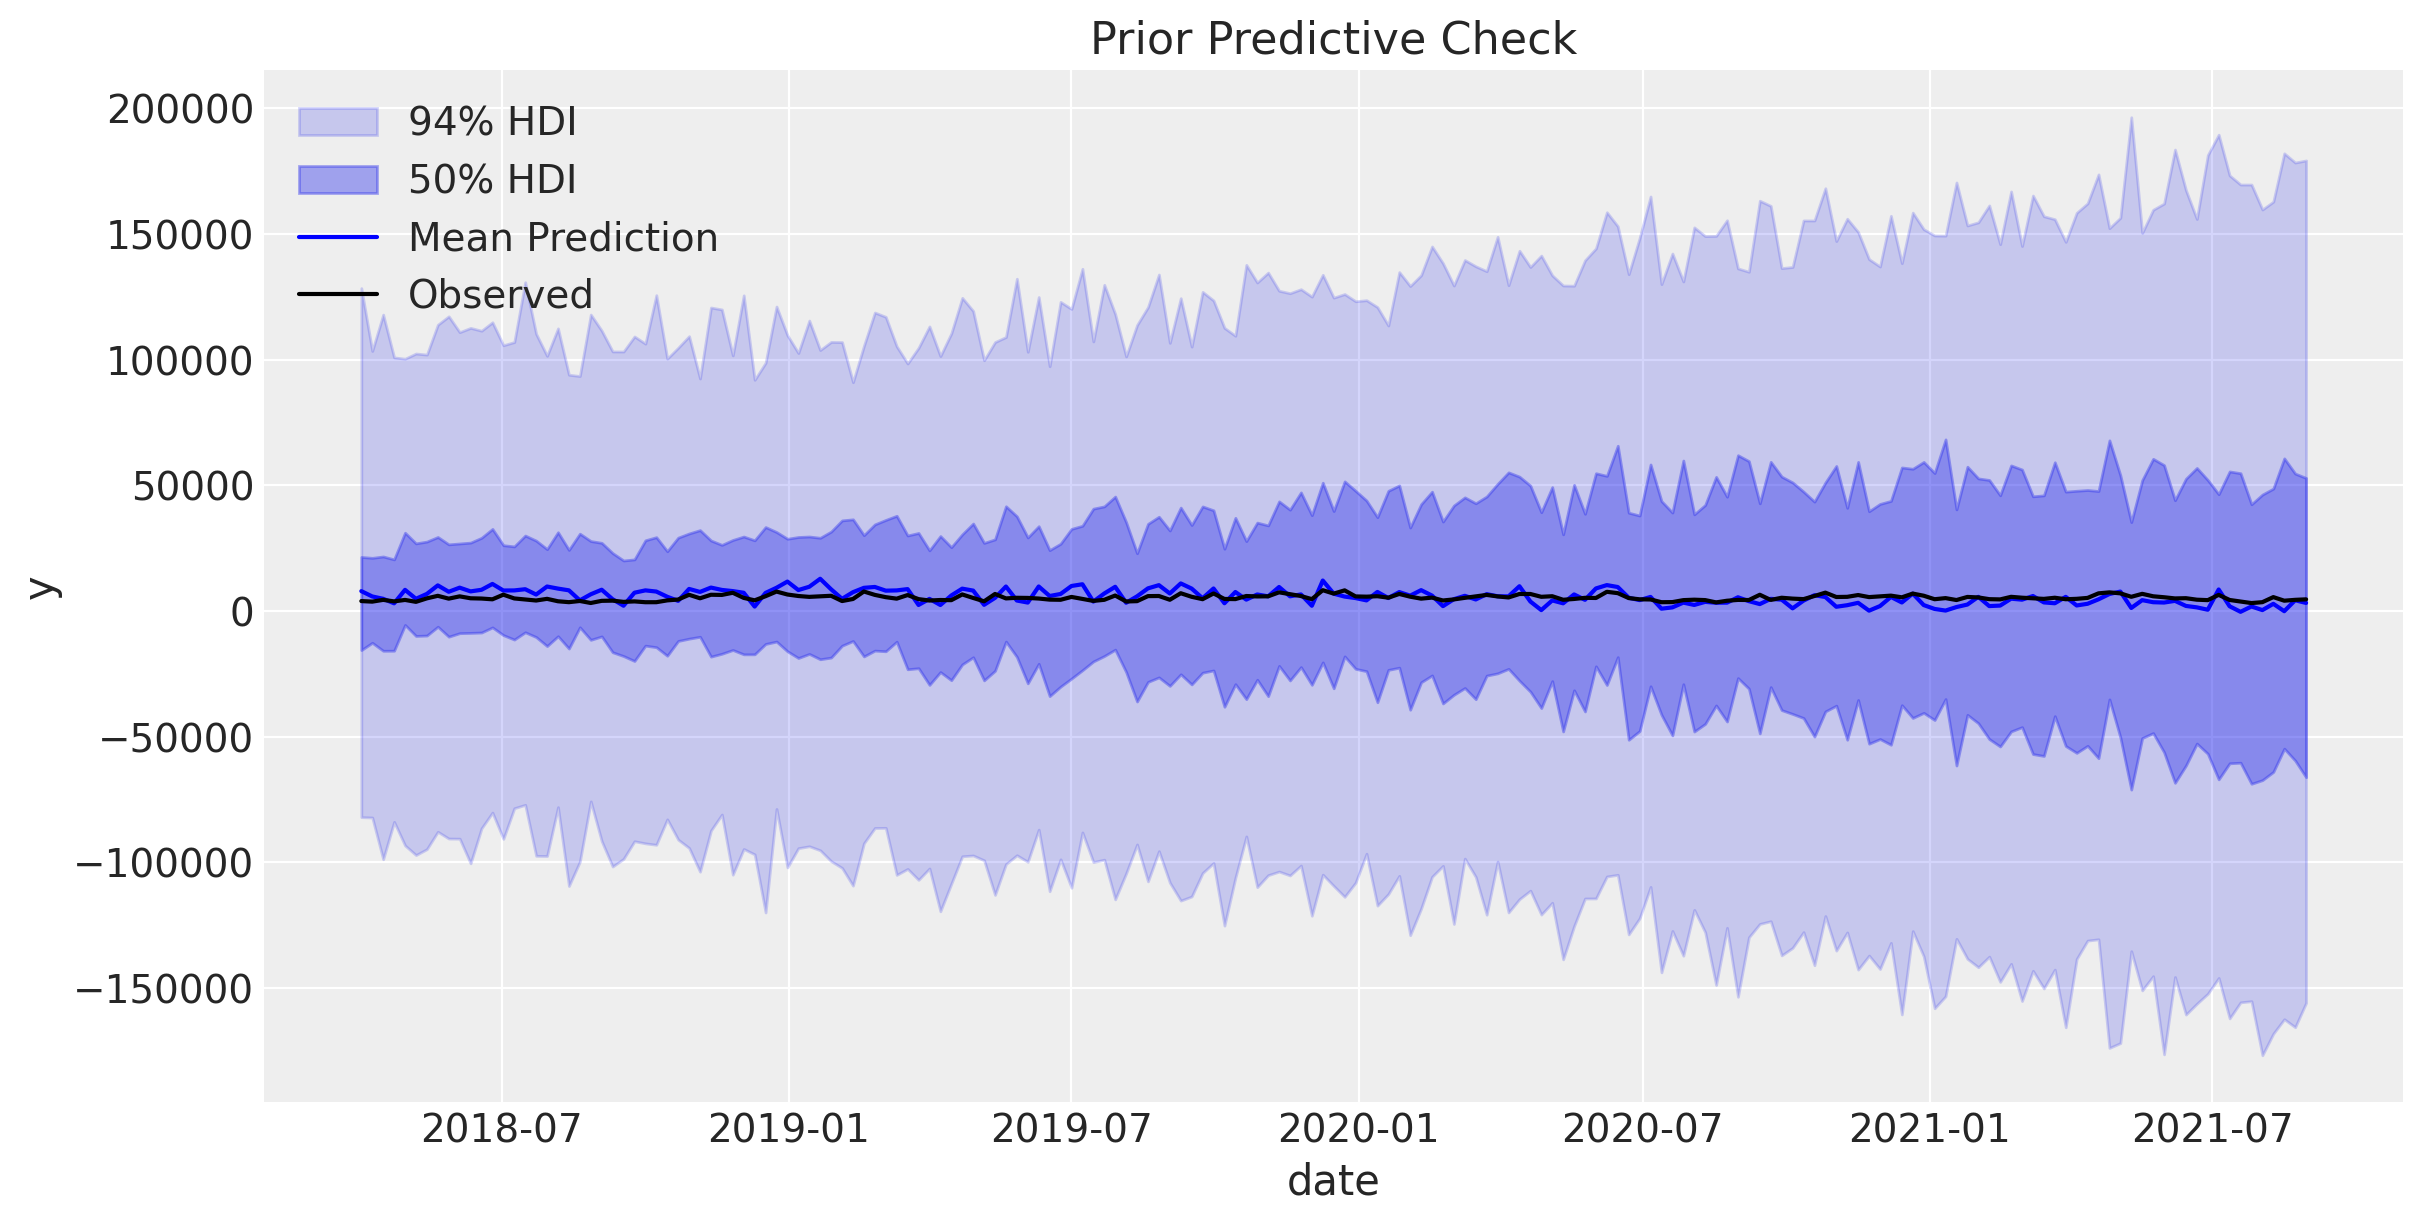

In [12]:
# Generate prior predictive samples using config
prior_samples = config['sampling']['prior_predictive']['samples']
mmm.sample_prior_predictive(X, y, samples=prior_samples, random_seed=rng)

# Plot prior predictive distribution
fig, ax = plt.subplots(figsize=(12, 6))
mmm.plot_prior_predictive(ax=ax, original_scale=True)
ax.legend(loc="upper left")
ax.set_title("Prior Predictive Check");

Overall, the prior predictive check looks good.

## Model Fitting

Now let's fit the model to our data using MCMC sampling. Observe that we can use different samplers by passing the `nuts_sampler` argument. For instance, we can use `numpyro`, `nutpie`, or `blackjax` samplers (see Other NUTS Samplers for more details).

In [13]:
# Fit the model using MCMC configuration from config file
mcmc_config = config['sampling']['mcmc']

_ = mmm.fit(
    X=X,
    y=y,
    chains=mcmc_config['chains'],
    target_accept=mcmc_config['target_accept'],
    nuts_sampler=mcmc_config['nuts_sampler'],
    random_seed=rng,
)

2025-10-17 02:15:00 - pymc_marketing.mmm.mmm.MMM - INFO - Starting model fitting
2025-10-17 02:15:00 - pymc_marketing.mmm.mmm.MMM - INFO - Fit input data shapes - X: (179, 7), y: (179,)
2025-10-17 02:15:00 - pymc_marketing.mmm.mmm.MMM - INFO - Fit parameters - progressbar: None, random_seed: Generator(PCG64)
2025-10-17 02:15:00 - pymc_marketing.mmm.mmm.MMM - INFO - Additional kwargs: ['chains', 'target_accept', 'nuts_sampler']
INFO:2025-10-17 02:15:01,305:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
2025-10-17 02:15:01 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]


Running chain 0:   5%|▌         | 100/2000 [00:02<00:18, 102.20it/s]





Running chain 0:  10%|█         | 200/2000 [00:04<00:22, 79.15it/s] 

c:\Users\David Rodriguez\Desktop\Developer\4M Project\pymc_marketing\mmmenv\Lib\site-packages\rich\live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

KeyboardInterrupt: 

## Model Diagnostics

After fitting, we should check the model quality. Let's start with divergences:

In [ ]:
# Check for divergences
n_divergences = mmm.idata["sample_stats"]["diverging"].sum().item()
print(f"Number of divergences: {n_divergences}")

if n_divergences == 0:
    print("✓ No divergences - sampling was successful!")
else:
    print("⚠ Warning: Model had divergences. Consider increasing target_accept.")

### Parameter Summary

Let's examine the estimated parameters:

In [ ]:
mmm.fit_result

In [ ]:
# Plot traces for key parameters
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
    ],
    compact=True,
    backend_kwargs={"figsize": (10, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Trace Plots", fontsize=16);

Good trace plots should show:

- **Left side**: Smooth, bell-shaped distributions
- **Right side**: "Fuzzy caterpillar" patterns (good mixing) with no trends

## Posterior Predictive Check

How well does our model fit the observed data?

In [ ]:
# Sample from posterior predictive distribution
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

# Plot model fit
fig = mmm.plot_posterior_predictive(original_scale=True)

The model captures the observed data well if the black dots (actual sales) fall within the shaded uncertainty bands.

## Contribution Analysis

Now for the fun part—understanding how much each component contributes to sales!

### Component Contributions Over Time

Let's visualize the contribution of each component of the model over time:

In [ ]:
fig = mmm.plot_components_contributions(original_scale=True)
plt.suptitle("Component Contributions to Sales", fontsize=16, y=1.02);

We see that we have captured the linear trend, events contributions and the seasonalities in the data. The remaining variation is due to the media channels, which is exactly what we want to understand.

### Waterfall Chart: Total Contribution by Component

A waterfall chart shows the total contribution of each component across the entire time period:

In [ ]:
# Waterfall decomposition
fig = mmm.plot_waterfall_components_decomposition();

This chart answers the question: "How much did each component contribute to total sales?"

### Channel Contribution Share

What percentage of media-driven sales comes from each channel?

In [ ]:
# Plot channel contribution share
fig = mmm.plot_channel_contribution_share_hdi(figsize=(7, 5));

### Direct Contribution Curves

These curves show the relationship between spend and contribution, accounting for saturation:

In [ ]:
# Plot direct contribution curves (saturation curves)
fig = mmm.plot_direct_contribution_curves()
plt.suptitle("Direct Contribution Curves", fontsize=16, y=1.02);

Notice how the curves flatten at higher spend levels—this is the saturation effect in action!

### Channel Contribution Grid

A complementary view of the media performance is to evaluate the channel contribution at different share spend levels for the complete training period. Concretely, if we denote by α the input channel data percentage level, so that for α=1 we have the model input spend data and for α=1.5 we have a 50% increase in the spend, then we can compute the channel contribution at a grid of α-values and plot the results:

In [ ]:
# Use contribution grid configuration from config file
grid_config = config['analysis']['contribution_grid']

mmm.plot_channel_contribution_grid(
    start=grid_config['start'],
    stop=grid_config['stop'],
    num=grid_config['num'],
    absolute_xrange=grid_config['absolute_xrange']
);